# DNN Multi-input: Tabular Transformer (MultiHeadAttention Experiment)

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [2]:
!pip3 install -U scikit-learn --upgrade
#!pip3 install optuna --upgrade
!pip3 install seaborn --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 82.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires seaborn<0.13,>=0.10.1, but you h

In [3]:
import gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']='cuda_malloc_async'

In [4]:
import sys

if not sys.warnoptions:
    import os, warnings
    warnings.simplefilter("once") # Change the filter in this process
    os.environ["PYTHONWARNINGS"] = "ignore"

In [5]:
warnings.filterwarnings("ignore")

In [6]:
#main modules for matrix calculations
import pandas as pd
import numpy as np
import scipy
import math
from collections import OrderedDict

#stats measures
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis

#main modules for visualisation
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from sklearn import tree
get_ipython().run_line_magic('matplotlib', 'inline')

In [7]:
# modules for forecasting
import tensorflow as tf
#import keras_tuner as kt
import optuna

2024-02-13 17:38:26.545037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 17:38:26.545165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 17:38:26.676685: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [8]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization, Dense, BatchNormalization
from tensorflow.keras.layers import Concatenate as Concat_layers
from tensorflow.keras import Input
from tensorflow.keras import Model as Model_tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from IPython.display import clear_output
from gc import collect
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import set_random_seed

In [9]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [10]:
np.random.seed(0)
tf.keras.utils.set_random_seed(0)
tf.config.experimental.enable_op_determinism()
tf.random.set_seed(0)

# Data Exploration

In [11]:
# https://www.kaggle.com/competitions/playground-series-s4e2/discussion/472433
cat_col_dict={"FAVC":"Frequent consumption of high caloric food",
             "FCVC":"Frequency of consumption of vegetables",
             "NCP":"Number of main meals",
             "CAEC":"Consumption of food between meals",
             "CH2O":"Consumption of water daily",
             "SCC":"Calories consumption monitoring",
             "FAF":"Physical activity frequency",
             "TUE":"Time using technology devices",
             "CALC":"Consumption of alcohol",
             "MTRANS":"Transportation used"}

In [12]:
data_dir='/kaggle/input/playground-series-s4e2/'
df_train = pd.read_csv(data_dir+"train.csv",index_col=0)
df_test = pd.read_csv(data_dir+"test.csv",index_col=0)

In [13]:
print("*"*33+"Train"+"*"*33)
display(df_train.head(2))
display(df_train.tail(2))
display(df_train.shape)
display(df_train.info())
print("\n"+"*"*33+"Test"+"*"*33)
display(df_test.head(2))
display(df_test.tail(2))
display(df_test.shape)
display(df_test.info())

*********************************Train*********************************


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
0,Male,24.443011,1.699998,81.66995,yes,yes,2.0,2.983297,Sometimes,no,2.763573,no,0.0,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.00000,yes,yes,2.0,3.000000,Frequently,no,2.000000,no,1.0,1.000000,no,Automobile,Normal_Weight


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
id,,,,,,,,,,,,,,,,,
20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II
20757,Male,26.680376,1.816547,118.134898,yes,yes,3.000000,3.000000,Sometimes,no,2.003563,no,0.684487,0.713823,Sometimes,Public_Transportation,Obesity_Type_II


(20758, 17)

<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF                             20758

None


*********************************Test*********************************


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.0,Sometimes,no,2.825629,no,0.8554,0.0,Sometimes,Public_Transportation
20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.0,Sometimes,no,3.000000,no,1.0000,0.0,Sometimes,Public_Transportation


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
id,,,,,,,,,,,,,,,,
34596,Male,21.000000,1.620000,53.000000,yes,yes,2.000000,3.0,Sometimes,no,2.000000,no,3.000000,2.000000,no,Public_Transportation
34597,Male,26.490926,1.812259,120.980508,yes,yes,2.744994,3.0,Sometimes,no,2.205977,no,1.304291,0.630866,Sometimes,Public_Transportation


(13840, 16)

<class 'pandas.core.frame.DataFrame'>
Index: 13840 entries, 20758 to 34597
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          13840 non-null  object 
 1   Age                             13840 non-null  float64
 2   Height                          13840 non-null  float64
 3   Weight                          13840 non-null  float64
 4   family_history_with_overweight  13840 non-null  object 
 5   FAVC                            13840 non-null  object 
 6   FCVC                            13840 non-null  float64
 7   NCP                             13840 non-null  float64
 8   CAEC                            13840 non-null  object 
 9   SMOKE                           13840 non-null  object 
 10  CH2O                            13840 non-null  float64
 11  SCC                             13840 non-null  object 
 12  FAF                             1

None

In [14]:
# select category columns
category_columns = df_train.select_dtypes(['object']).columns
# select numeric columns
numeric_columns= df_train.select_dtypes(['float64']).columns

In [15]:
def df_num_dqr_table(df, numeric_columns):
    #finding % of missing values in numeric features
    numeric_columns_missing  = 100 * (df[numeric_columns].isnull().sum()/df.shape[0])
    df_numeric_missing = pd.DataFrame(numeric_columns_missing, columns=['%missing'])

    # adding % missing an cardinality to data report of numeric features
    numeric_columns_card = df[numeric_columns].nunique()
    df_numeric_card = pd.DataFrame(numeric_columns_card, columns=['card'])

    df_table_numeric = df[numeric_columns].describe().T

    df_numeric_columns_dqr = pd.concat([df_table_numeric, df_numeric_missing, df_numeric_card], axis=1)

    return df_numeric_columns_dqr

df_numeric_columns_data_quality_report_table =df_num_dqr_table(df_train,numeric_columns)
display(df_numeric_columns_data_quality_report_table)
display(df_train[category_columns].describe().T)

,count,mean,std,min,25%,50%,75%,max,%missing,card
Age,20758.0,23.841804,5.688072,14.00,20.000000,22.815416,26.000000,61.000000,0.0,1703
Height,20758.0,1.700245,0.087312,1.45,1.631856,1.700000,1.762887,1.975663,0.0,1833
Weight,20758.0,87.887768,26.379443,39.00,66.000000,84.064875,111.600553,165.057269,0.0,1979
FCVC,20758.0,2.445908,0.533218,1.00,2.000000,2.393837,3.000000,3.000000,0.0,934
NCP,20758.0,2.761332,0.705375,1.00,3.000000,3.000000,3.000000,4.000000,0.0,689
CH2O,20758.0,2.029418,0.608467,1.00,1.792022,2.000000,2.549617,3.000000,0.0,1506
FAF,20758.0,0.981747,0.838302,0.00,0.008013,1.000000,1.587406,3.000000,0.0,1360
TUE,20758.0,0.616756,0.602113,0.00,0.000000,0.573887,1.000000,2.000000,0.0,1297


,count,unique,top,freq
Gender,20758,2,Female,10422
family_history_with_overweight,20758,2,yes,17014
FAVC,20758,2,yes,18982
CAEC,20758,4,Sometimes,17529
SMOKE,20758,2,no,20513
SCC,20758,2,no,20071
CALC,20758,3,Sometimes,15066
MTRANS,20758,5,Public_Transportation,16687
NObeyesdad,20758,7,Obesity_Type_III,4046


## Visualisation

### Distributions of Numerical columns

In [16]:
def plot_num_box(train, test):
    fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(12,24))
    for (i,col) in enumerate(test.select_dtypes(np.float64).columns):

        sns.boxplot(data=train,  x=col , ax=axes[i,0])

        sns.boxplot(data=test,  x=col , ax=axes[i,1])

        if col in cat_col_dict.keys():
            title=cat_col_dict[col] +" ("+ (col) +")"
        else:
            title=col
        axes[i,0].title.set_text(title+"_train")
        axes[i,1].title.set_text(title+"_test")
    fig.tight_layout()
    plt.show()
    plt.close()

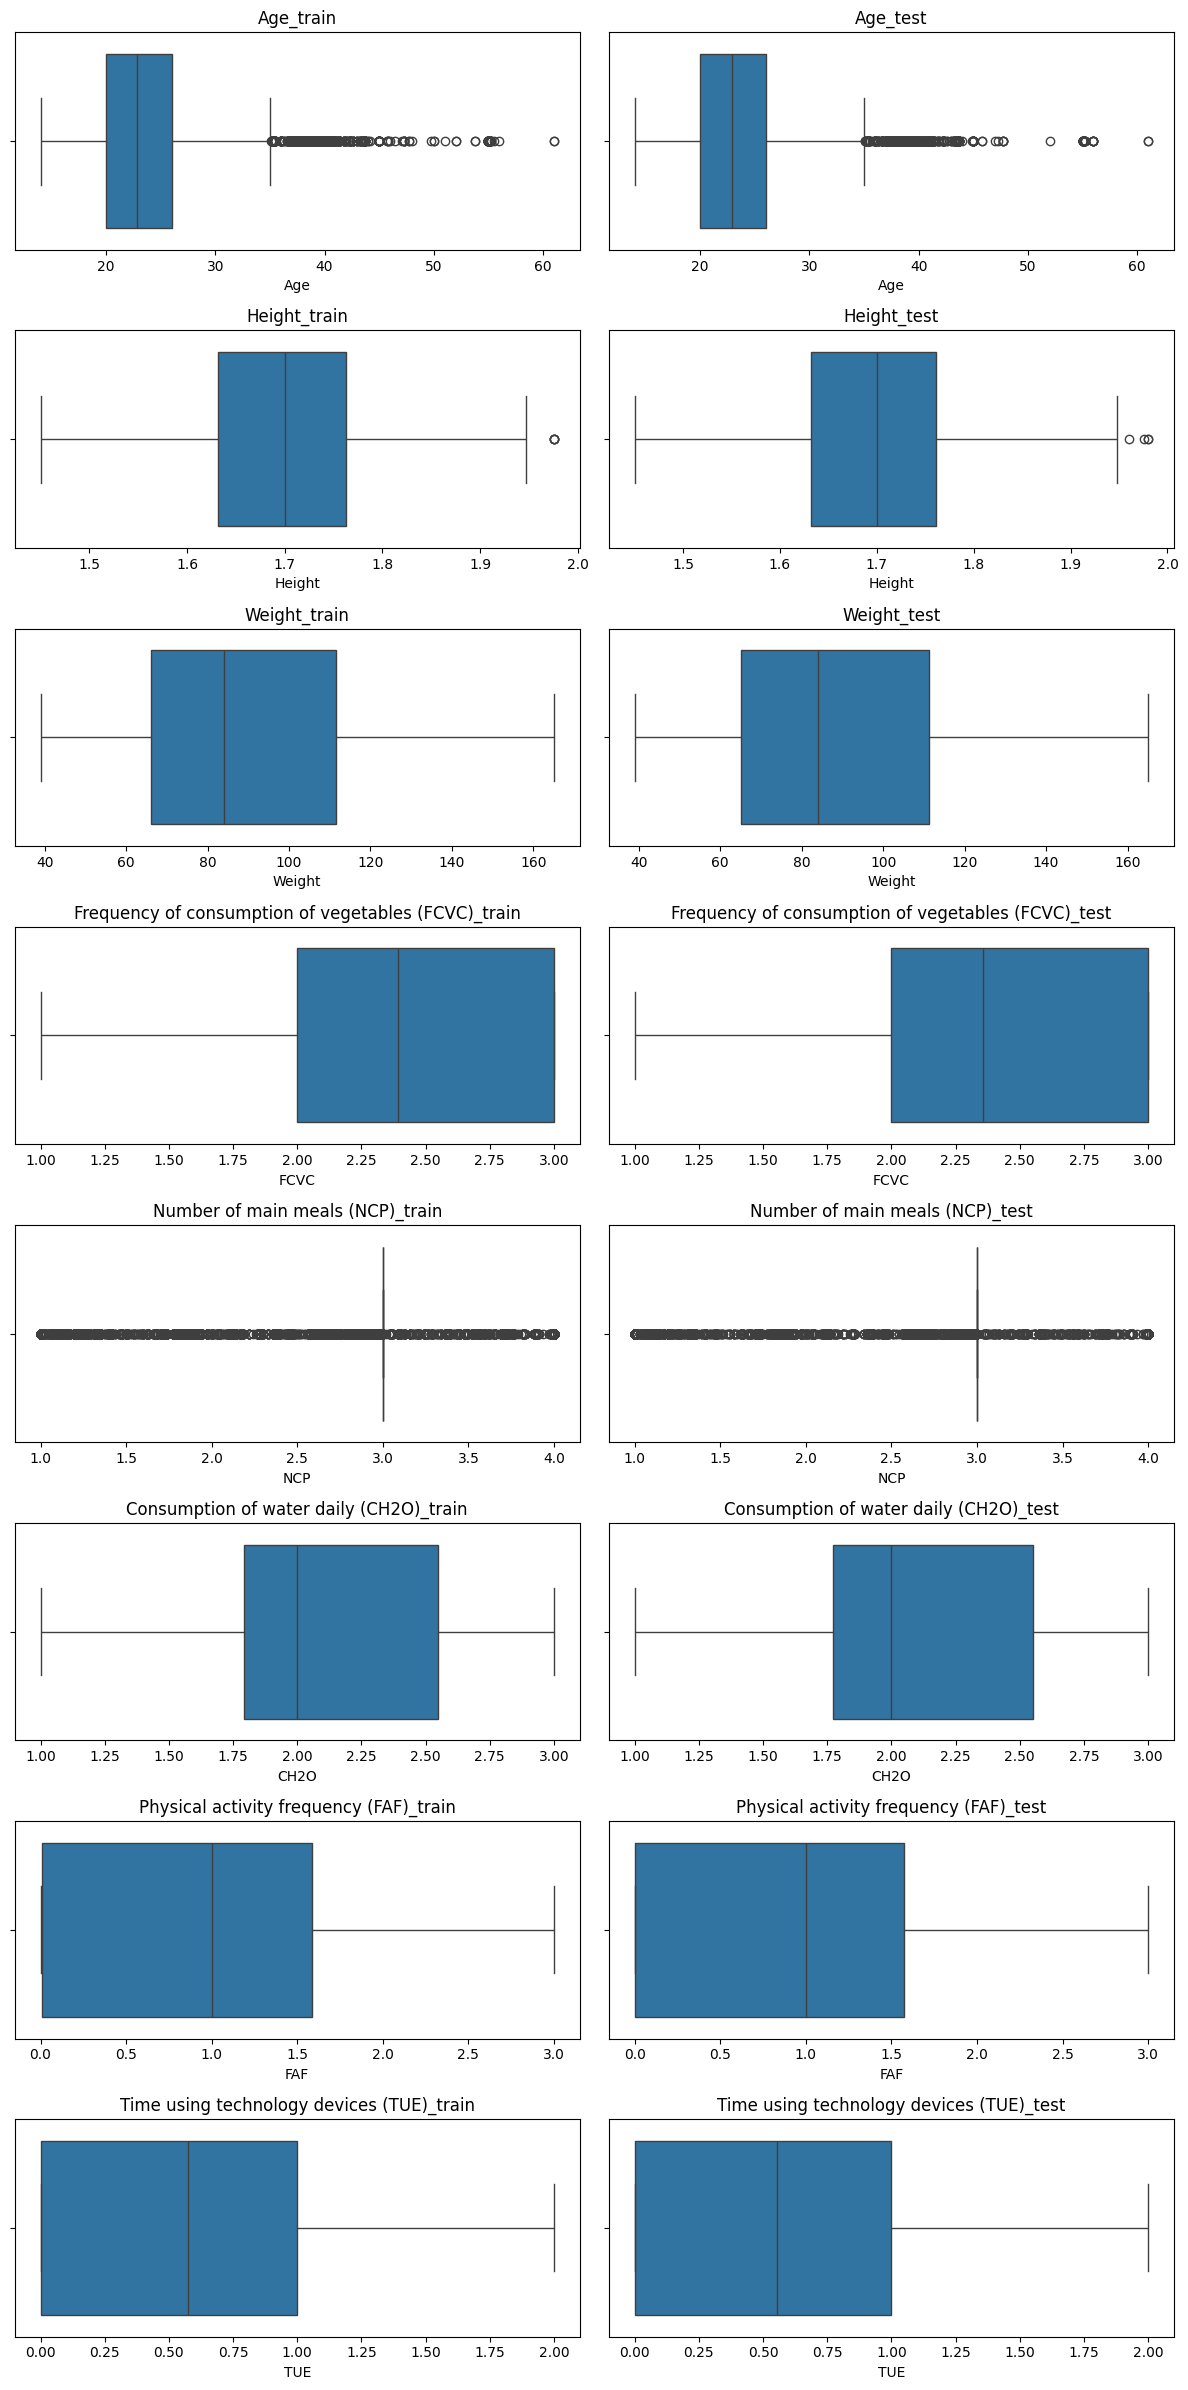

In [17]:
plot_num_box(df_train, df_test)

In [18]:
def plot_num_kde(train, test):
    fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(12,24))
    for (i,col) in enumerate(test.select_dtypes(np.float64).columns):

        sns.kdeplot(data=train,  x=col , ax=axes[i,0])

        sns.kdeplot(data=test,  x=col , ax=axes[i,1])

        if col in cat_col_dict.keys():
            title=cat_col_dict[col] +" ("+ (col) +")"
        else:
            title=col
        axes[i,0].title.set_text(title+"_train")
        axes[i,1].title.set_text(title+"_test")
    fig.tight_layout()
    plt.show()
    plt.close()

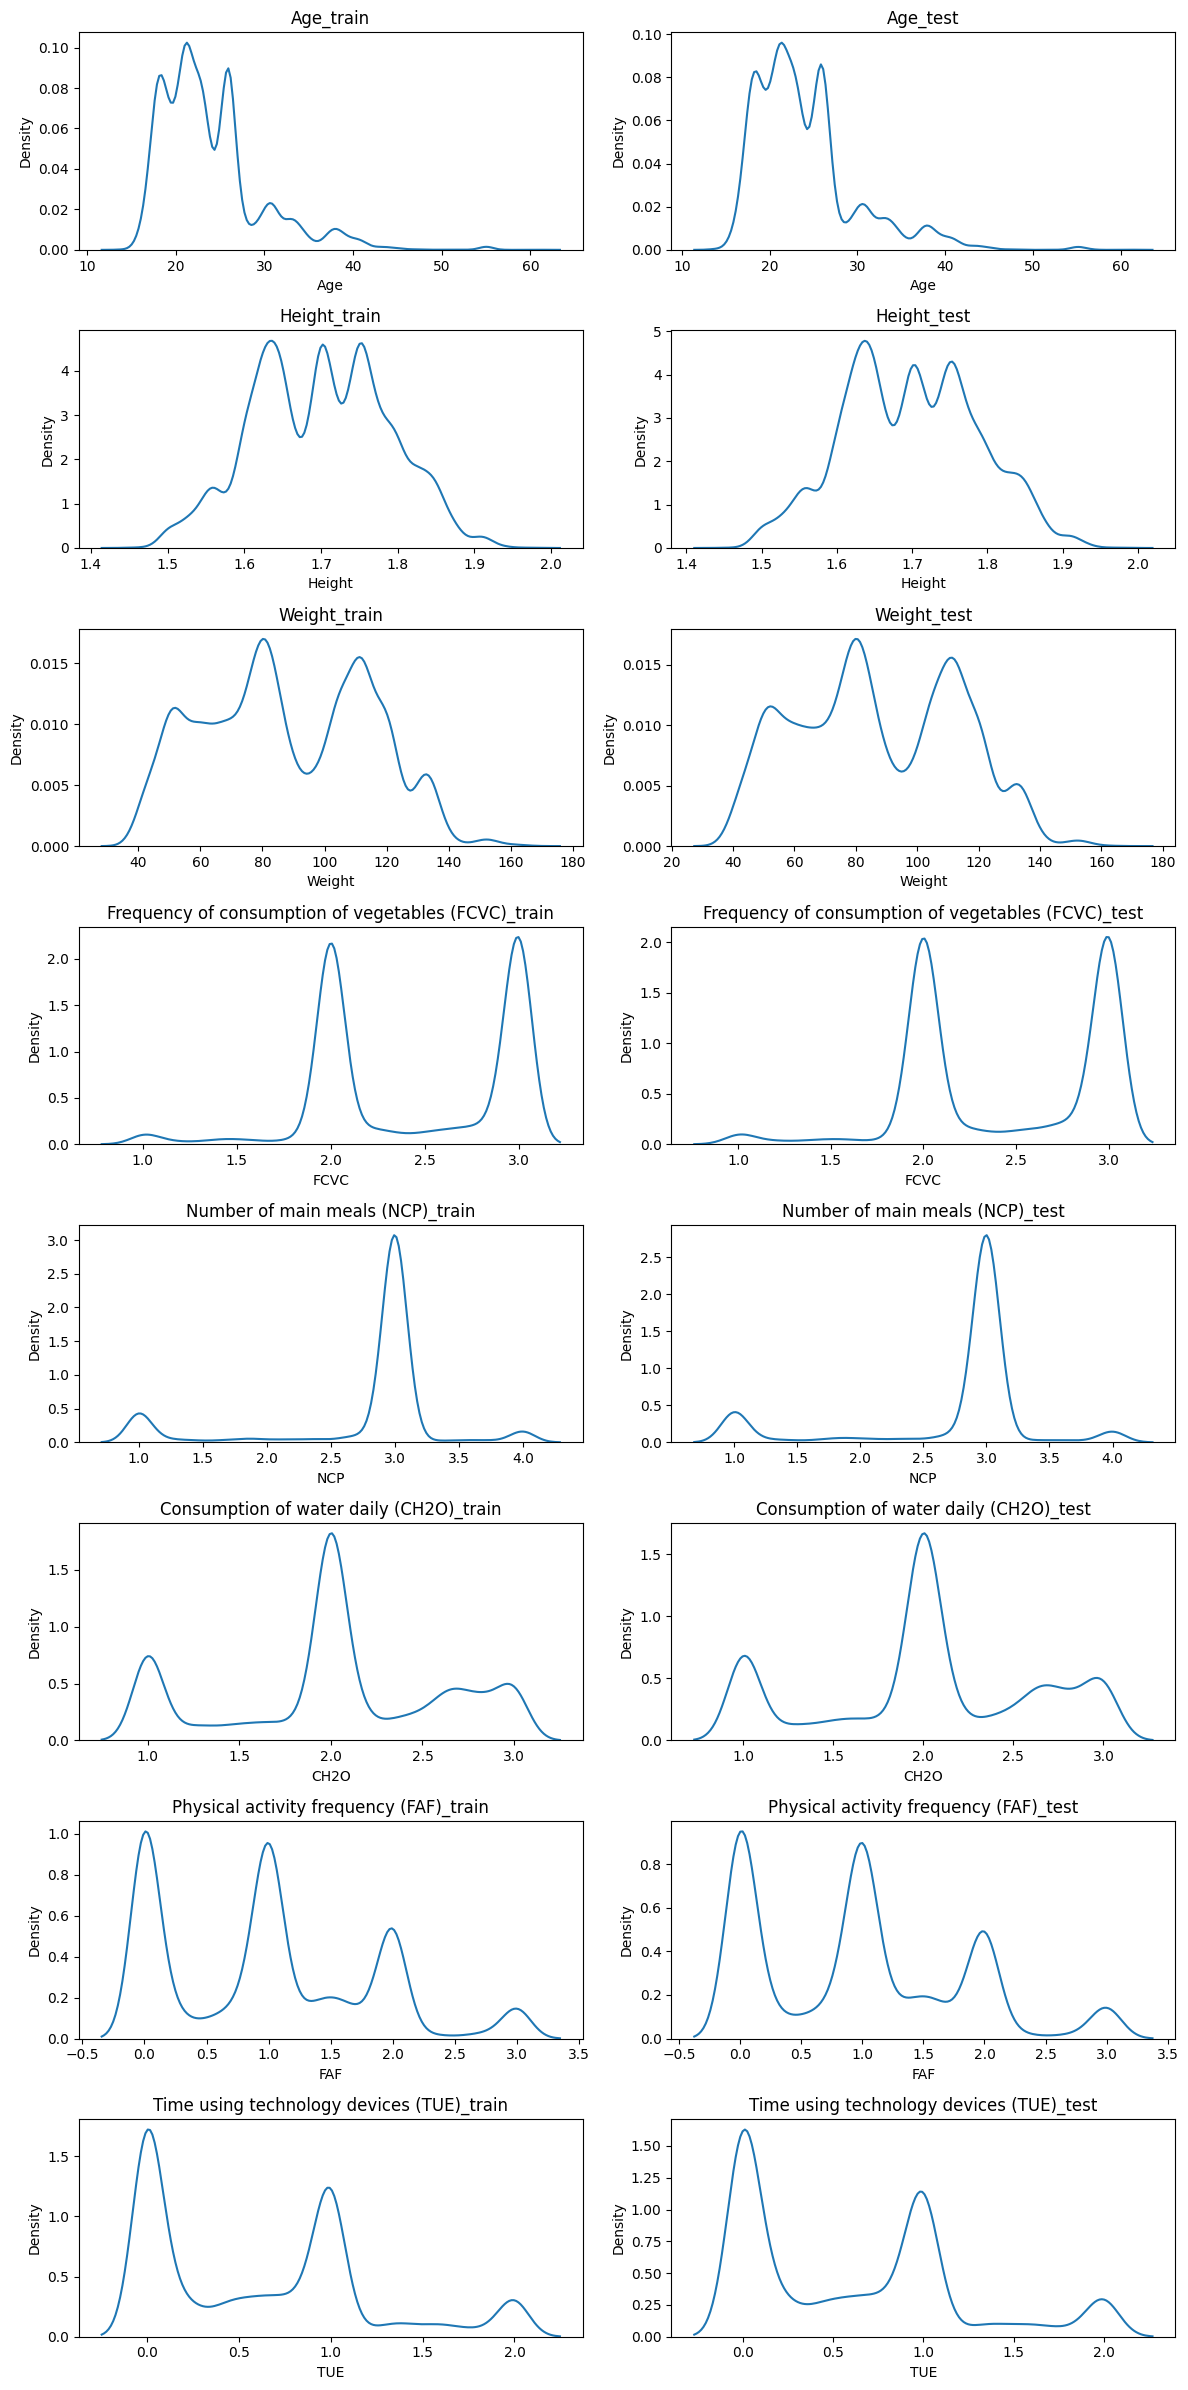

In [19]:
plot_num_kde(df_train, df_test)

### Numerical col distributions by target category

In [20]:
def plot_num_target(df):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,24),sharey=True)
    for (i,col) in enumerate(numeric_columns):
        c=0
        r=i
        if i>=4:
            c=1
            r=i-4
        sns.boxplot(data=df, x=col, y='NObeyesdad' ,
                    order = df['NObeyesdad'].value_counts().index.to_list(),
                      legend="full", ax=axes[r,c])
        if col in cat_col_dict.keys():
            title=cat_col_dict[col] +" ("+ (col) +")"
        else:
            title=col
        axes[r,c].title.set_text(title)
    fig.tight_layout()
    #plt.savefig("numeric_cols.png", dpi=150)
    plt.show()
    plt.close()

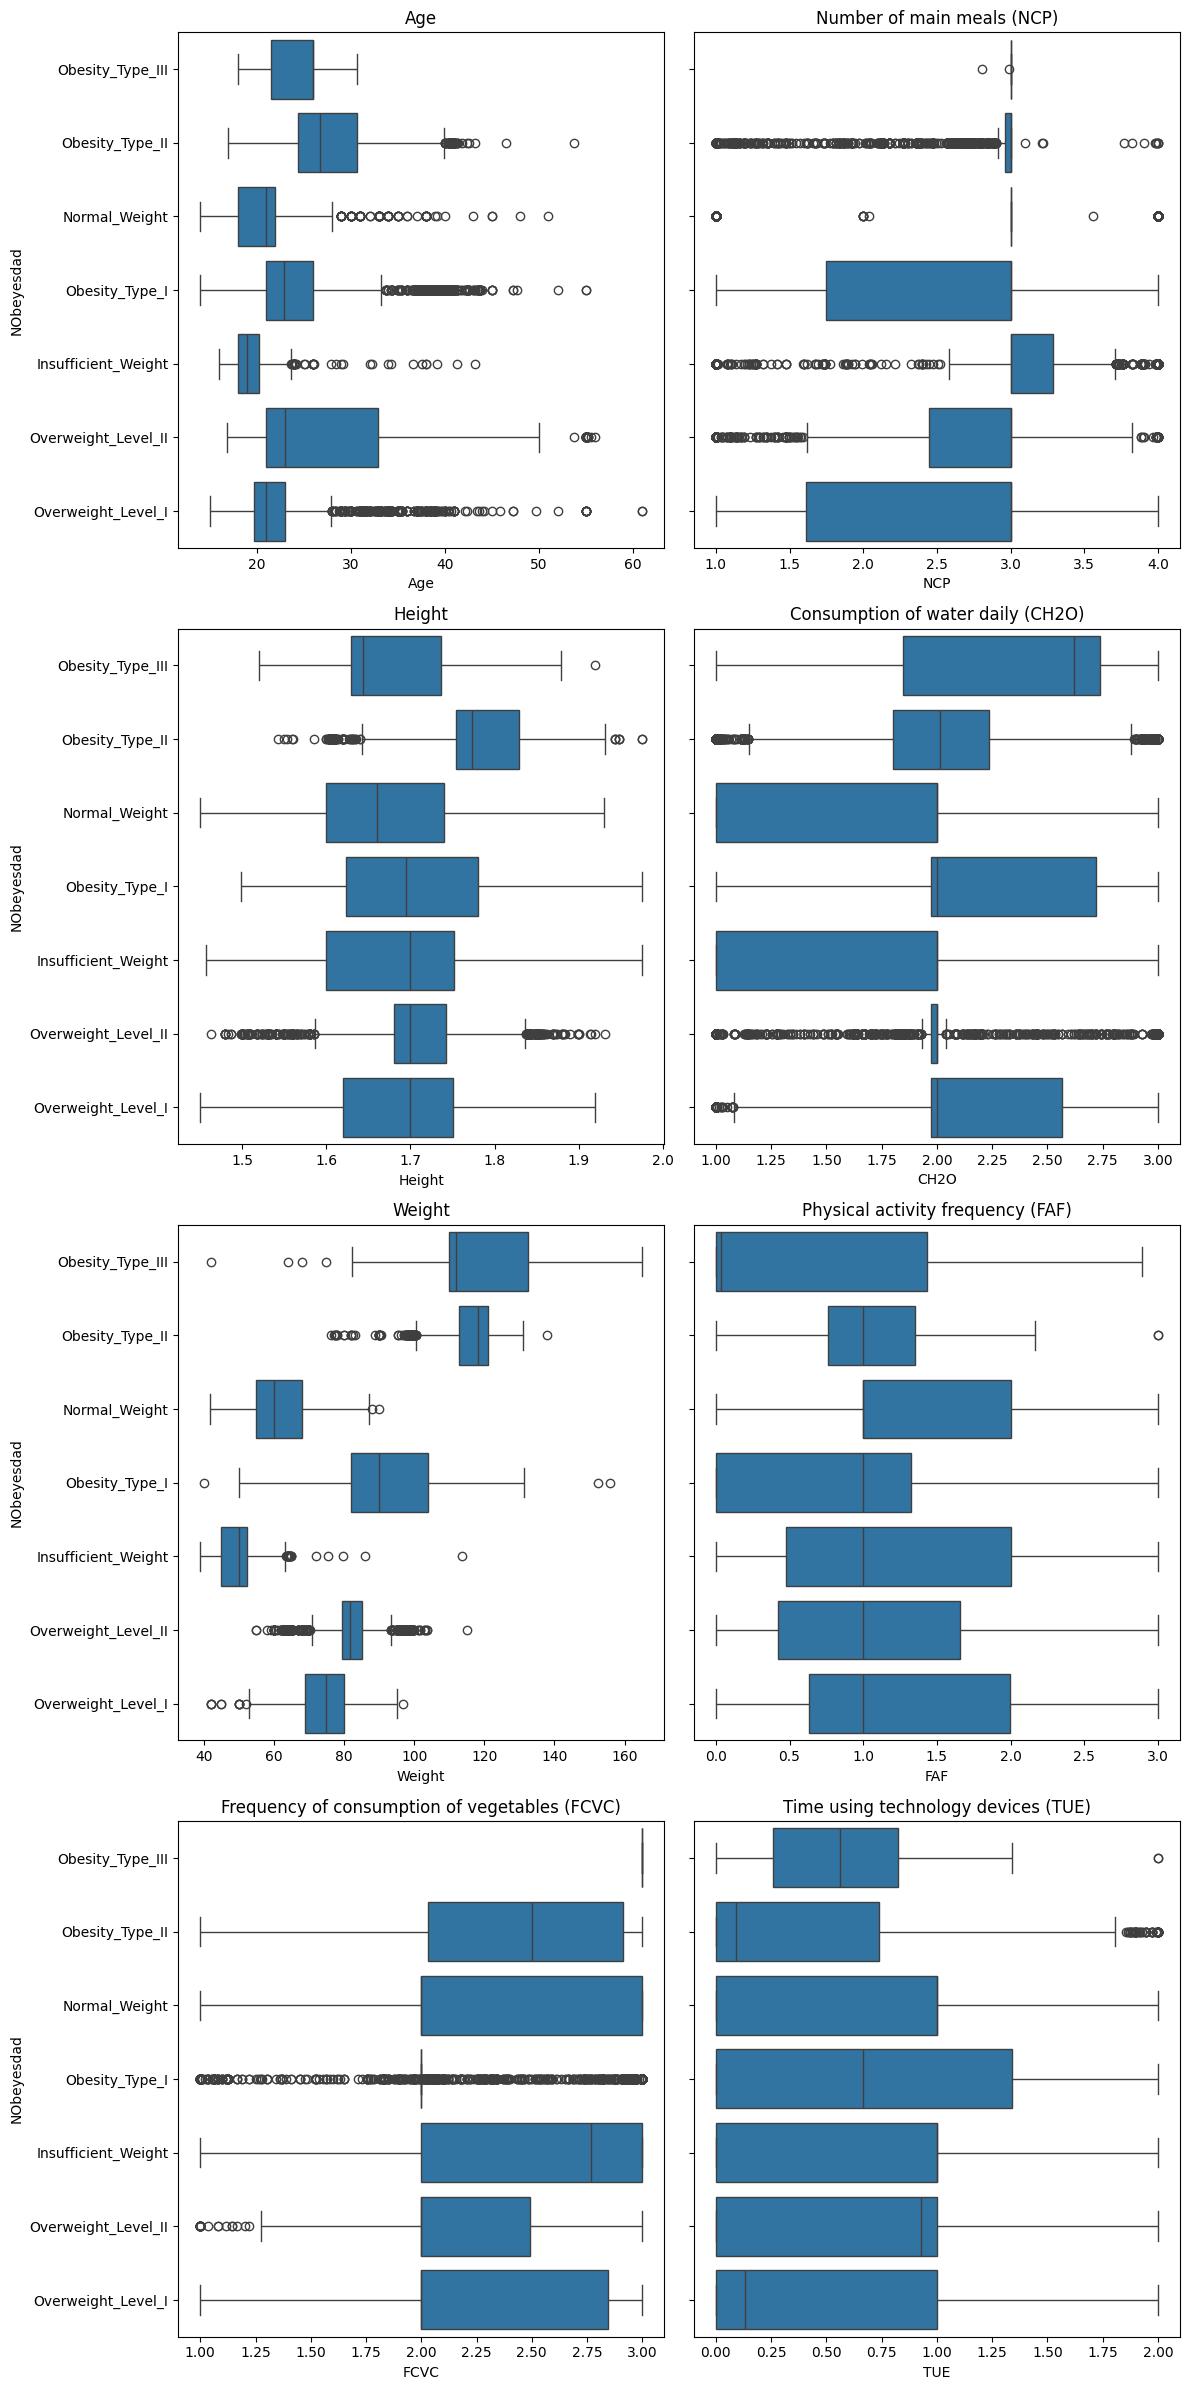

In [21]:
plot_num_target(df_train)

In [22]:
def plot_num_kde_target(df):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12,24))
    for (i,col) in enumerate(numeric_columns):
        c=0
        r=i
        if i>=4:
            c=1
            r=i-4
        sns.kdeplot(data=df, x=col, hue='NObeyesdad' ,
                      legend="full", ax=axes[r,c])
        if col in cat_col_dict.keys():
            title=cat_col_dict[col] +" ("+ (col) +")"
        else:
            title=col
        axes[r,c].title.set_text(title)
    fig.tight_layout()
    #plt.savefig("numeric_cols_kde.png", dpi=150)
    plt.show()
    plt.close()

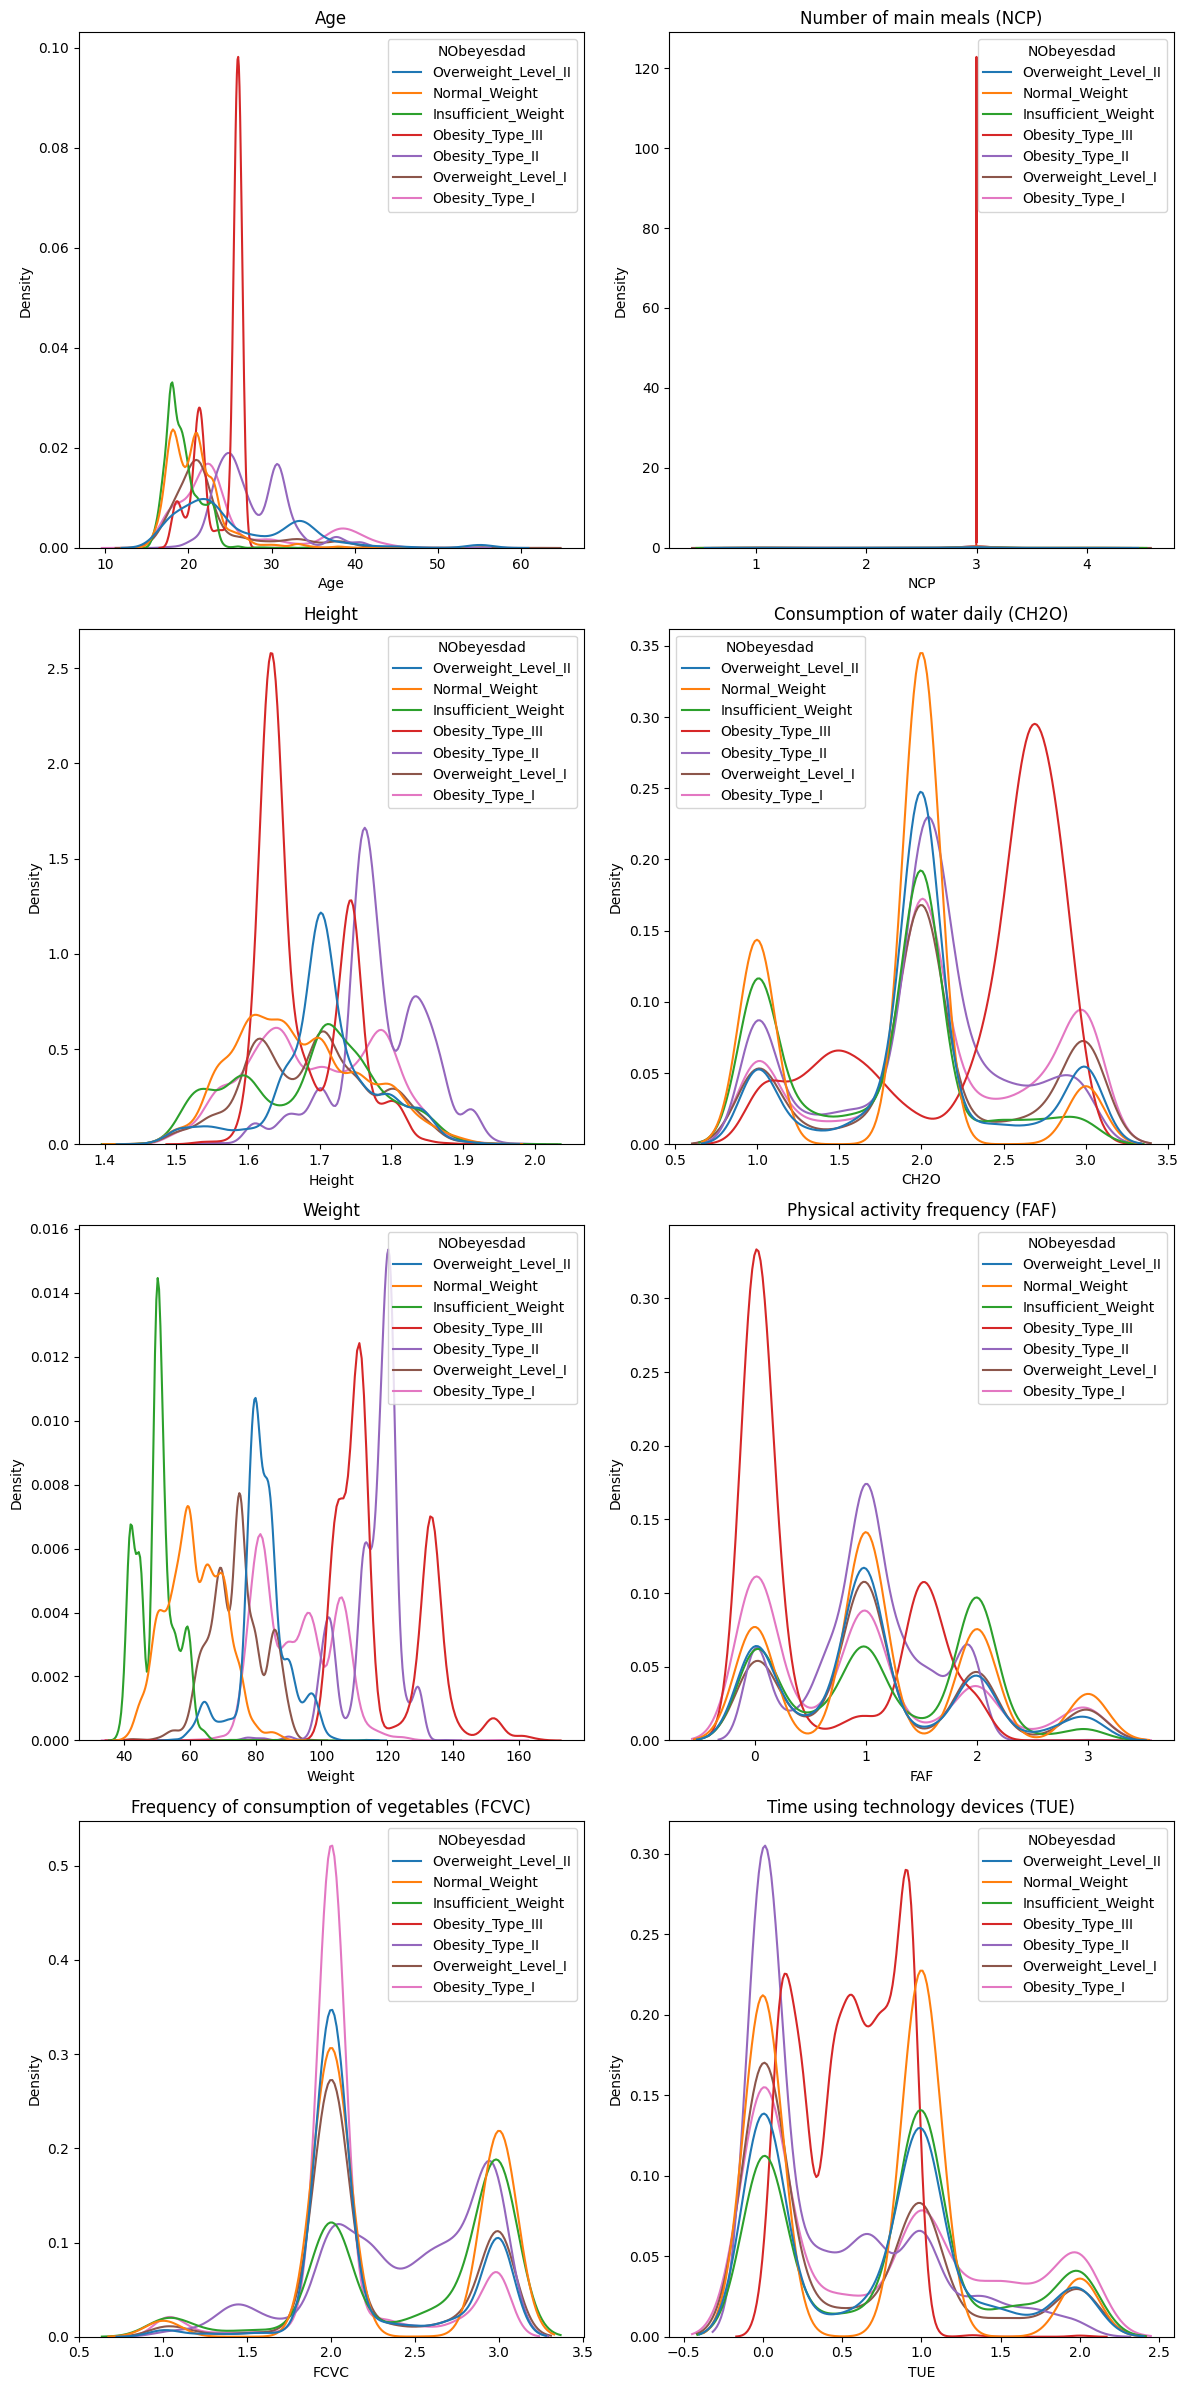

In [23]:
plot_num_kde_target(df_train)

In [24]:
import scipy.stats as stats

In [25]:
def plot_num_QQ(df):

    for (i,col) in enumerate(numeric_columns):
        uniques=df['NObeyesdad'].unique()
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,6),sharey=True, sharex=True )
        for (j,cat) in enumerate(uniques):
            c=j
            r=0
            if j>=4:
                c=j-4
                r=1
            stats.probplot(df[df['NObeyesdad'] == cat][col], dist="norm", plot=axes[r,c])
        if col in cat_col_dict.keys():
            title=cat_col_dict[col] +" ("+ (col) +")"
        else:
            title=col
        fig.suptitle( title, fontsize=12)

    plt.close()

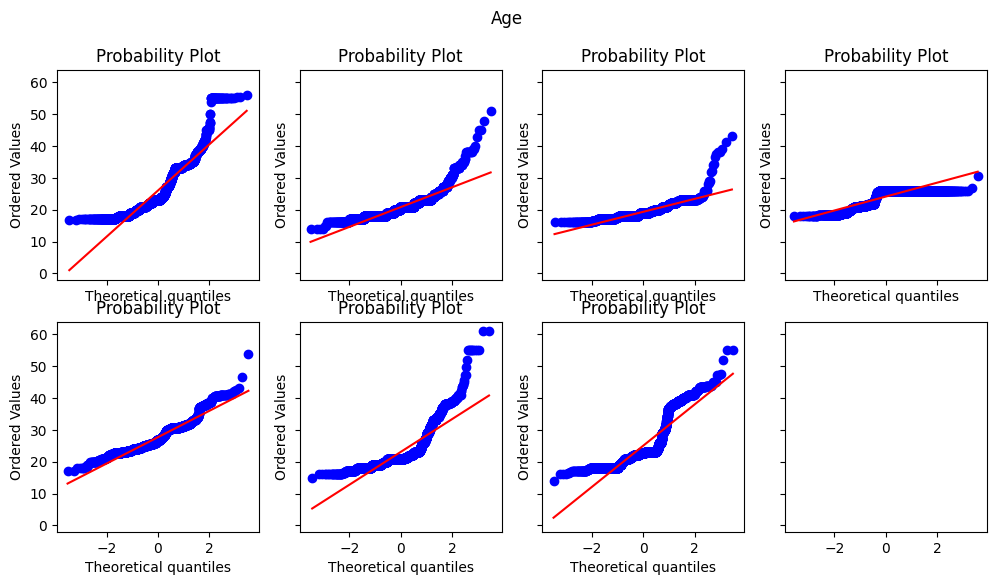

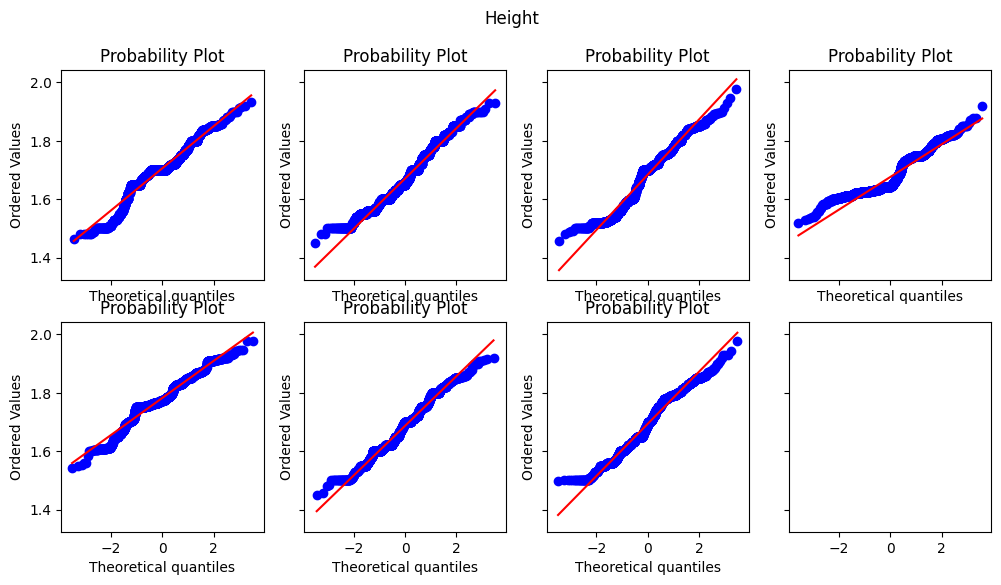

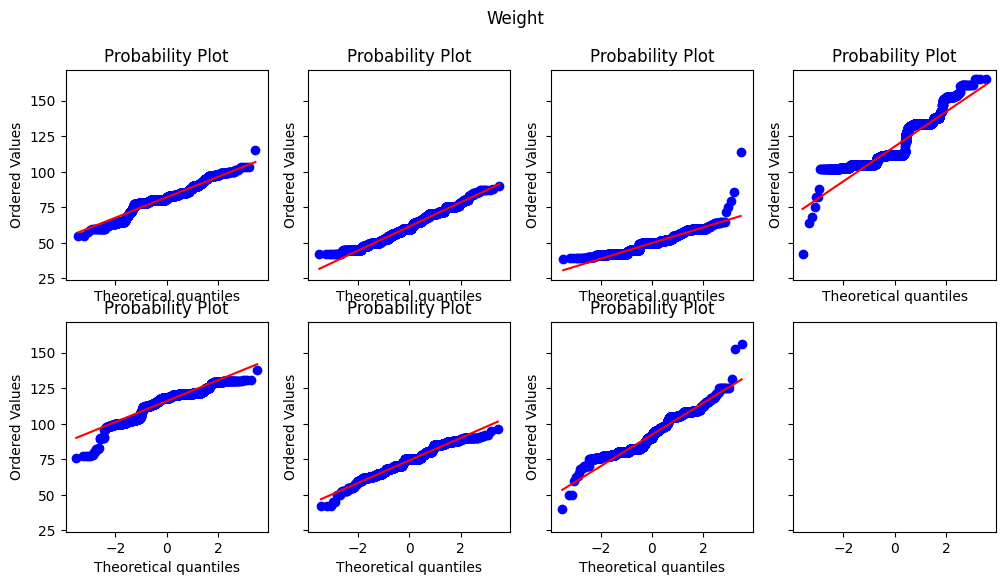

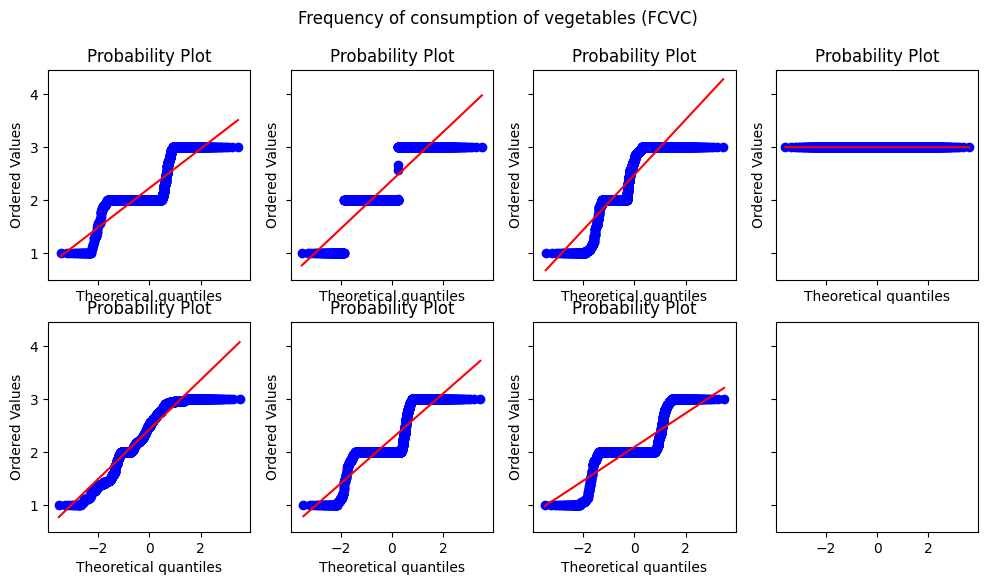

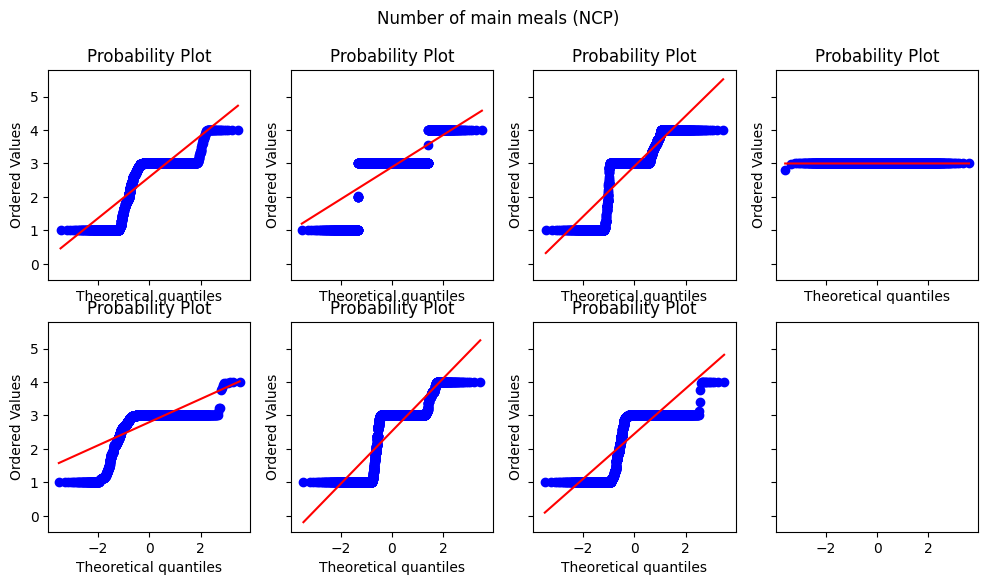

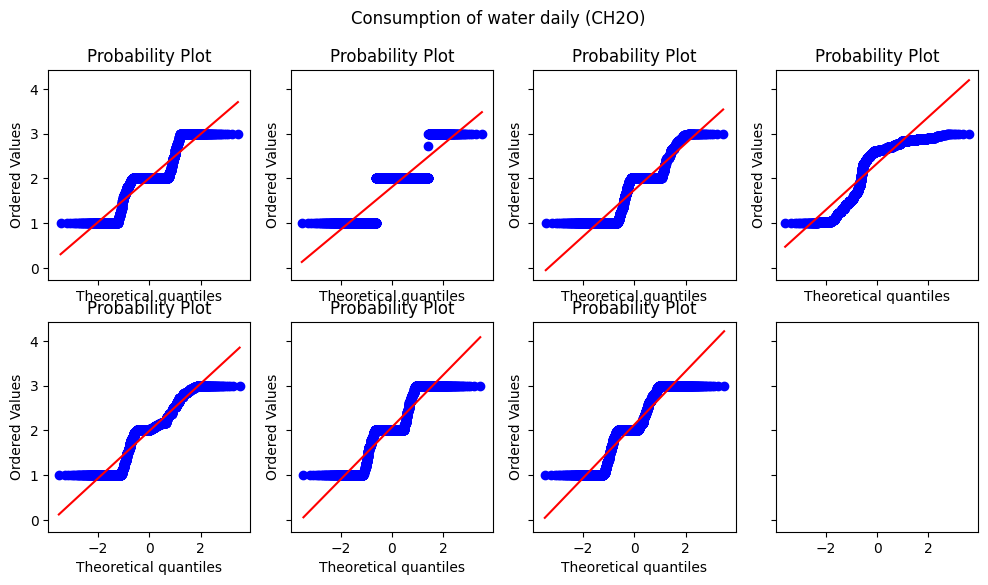

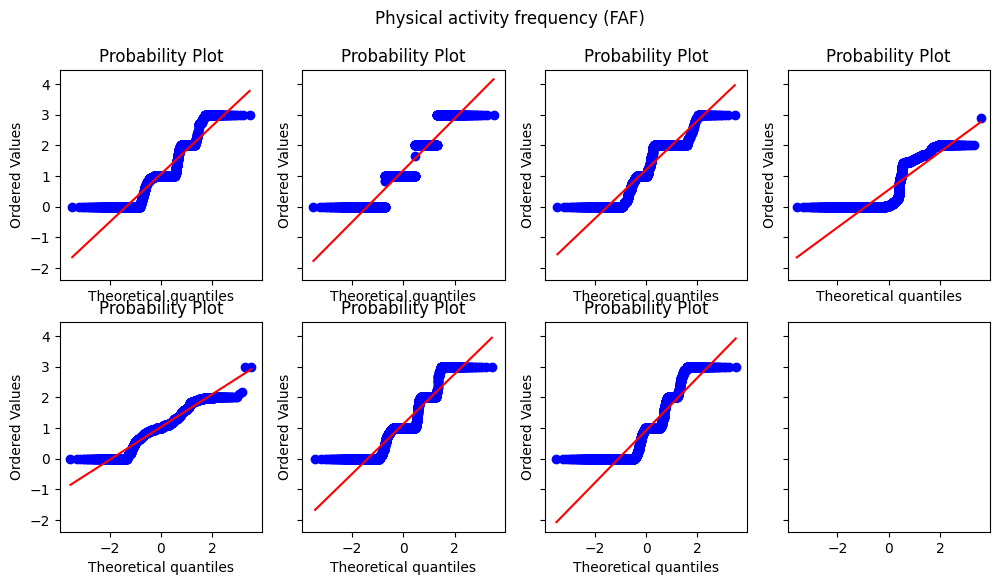

In [26]:
plot_num_QQ(df_train)

### Notes
* CALC ( consumption of Alcohol) feature have "always" category which is in test but not in train
* So few smokers in dataset
* (NCP) Number of main meals seem to be less correlated as it have same mean for target in all categories in train.
* All category features suitable for one-hot encode they have low cardinality

# Preprocessing

In [27]:
# downsizing dfs
def shrink_size(*args):
    for df in args:
        #print("*"*66)
        #display(df.memory_usage(deep=True).sum())
        df[df.select_dtypes(np.float64).columns] = df.select_dtypes(np.float64).astype(np.float32)
        df[df.select_dtypes(np.int64).columns] = df.select_dtypes(np.int64).astype(np.int32)
        df[df.select_dtypes("object").columns] = df.select_dtypes("object").astype("string")
        display(df.memory_usage(deep=True).sum())
    return args

In [28]:
df_train, df_test = shrink_size(df_train, df_test)

12846468

7553057

### Feature Engineering

In [29]:
def add_features(df, sec_feat=True):
    # normalizing weight by height
    df["BMI"]=df["Weight"]/df["Height"]**2
    df['CALC']=np.where(df['CALC']=='Always','Frequently',df['CALC'])
    return df

In [30]:
df_train=add_features(df_train)
df_test=add_features(df_test)

In [31]:
df_train.head(2)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
id,,,,,,,,,,,,,,,,,,
0,Male,24.44301,1.699998,81.669952,yes,yes,2.0,2.983297,Sometimes,no,2.763573,no,0.0,0.976473,Sometimes,Public_Transportation,Overweight_Level_II,28.259565
1,Female,18.00000,1.560000,57.000000,yes,yes,2.0,3.000000,Frequently,no,2.000000,no,1.0,1.000000,no,Automobile,Normal_Weight,23.422094


### Train-val-test split

In [32]:
#split ratio:80, 10, 10
train, val, test = np.split(df_train.sample(frac=1), [int(0.8*len(df_train)), int(0.9*len(df_train))])

In [33]:
print(f"train: {train.shape}, val: {val.shape}, test: {test.shape }")

train: (16606, 18), val: (2076, 18), test: (2076, 18)


### Preprocesssing for training

In [34]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

In [35]:
preprocess_columns=['Gender', 'Age','BMI','Weight', 'Height', 'family_history_with_overweight', 'FAVC', 'FCVC',
                     'NCP', 'CAEC','CALC',  'CH2O', 'SCC', 'FAF', 'TUE', 'MTRANS','SMOKE',]
category_columns_x=['Gender', 'family_history_with_overweight', 'FAVC', 'SCC',  'MTRANS','SMOKE']
numeric_columns_x=['Age', 'BMI', 'Weight', 'Height', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
ordinal_columns_x=['CALC','CAEC']

encoder = ColumnTransformer(
    transformers=[
        ("one-hot", OneHotEncoder(handle_unknown='ignore', drop="first",
                                  feature_name_combiner="concat"), category_columns_x),
        ("CALC",OrdinalEncoder(categories=[["no", "Sometimes", "Frequently"]]), ["CALC"] ),
        ("CAEC",OrdinalEncoder(categories=[["no", "Sometimes", "Frequently", "Always"]]), ["CAEC"] )],
    remainder="passthrough", verbose_feature_names_out=True)

preprocess_pipe = Pipeline(steps=[
        ('encoder', encoder),
         ("normalize",MinMaxScaler()),
        ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = encoder.get_feature_names_out() )))
        ],verbose=True)
preprocessor=preprocess_pipe.fit(train[preprocess_columns])

[Pipeline] ........... (step 1 of 3) Processing encoder, total=   0.1s
[Pipeline] ......... (step 2 of 3) Processing normalize, total=   0.0s
[Pipeline] ........ (step 3 of 3) Processing pandarizer, total=   0.0s


In [36]:
X_train=train[preprocess_columns]
X_valid=val[preprocess_columns]
X_test=test[preprocess_columns]
X_final=df_test[preprocess_columns]
X_train=preprocess_pipe.transform(X_train)
X_valid=preprocess_pipe.transform(X_valid)
X_test=preprocess_pipe.transform(X_test)
X_final=preprocess_pipe.transform(X_final)

In [37]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train[['NObeyesdad']])

LabelEncoder()

In [38]:
y_train=train[['NObeyesdad']]
y_valid=val[['NObeyesdad']]
y_test=test[['NObeyesdad']]
y_train=le.transform(y_train)
y_valid=le.transform(y_valid)
y_test=le.transform(y_test)

# Feature Selection

In [39]:
from dataclasses import dataclass
@dataclass
class G:
    num_features=len(X_train.columns)
    valid_preds={}
    test_preds={}
    acc_per_class={}

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [41]:
def classification_report(y_test, y_pred, set_type , model_type):
    y_pred_shape=len(y_pred.shape)
    if y_pred_shape==2:
        test_labels=np.zeros((y_test.size, y_test.max() + 1))
        test_labels[np.arange(y_test.size), y_test] = 1
    else:
        test_labels=y_test
    # overall accuracy score
    print("****** Overall Accuracy Score ********")
    print(accuracy_score(test_labels, y_pred))
    print("\n")

    # accuracy score for each class
    if y_pred_shape==2:
        cm = confusion_matrix(le.inverse_transform(tf.math.argmax(test_labels, -1).numpy()),
                              le.inverse_transform(tf.math.argmax(y_pred, -1).numpy()))
    else:
        cm = confusion_matrix(le.inverse_transform(test_labels),
                              le.inverse_transform(y_pred))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm.diagonal()
    print("****** Accuracy score of each class ********")
    display(pd.DataFrame(data=cm.diagonal().reshape(1,-1), columns=le.classes_))
    G.acc_per_class[model_type+"_"+set_type]=pd.DataFrame(data=cm.diagonal().reshape(1,-1), columns=le.classes_)

    print("\n")

    print("****** Classification report ********")
    # Print performance details
    print(metrics.classification_report(test_labels, y_pred))
    print("\n")

    # Print confusion matrix
    print("****** Confusion Matrix ******")
    if y_pred_shape==2:
        display(pd.crosstab(le.inverse_transform(tf.math.argmax(test_labels, -1).numpy()),
                            le.inverse_transform(tf.math.argmax(y_pred, -1).numpy()),
                            rownames=['True'], colnames=['Predicted'], margins=True))
    else:
        display(pd.crosstab(le.inverse_transform(test_labels),
                            le.inverse_transform(y_pred),
                            rownames=['True'], colnames=['Predicted'], margins=True))

In [42]:
def print_cv(cv_result):
    print(f"All scores: {cv_result['test_score']}")
    print(f"Cross validated average accuracy: {cv_result['test_score'].mean():.5f}, std: {cv_result['test_score'].std():.5f}")
    return cv_result['test_score'].mean()

In [43]:
# Cv set
X_train_cv=pd.concat([X_train,X_valid],axis=0)
y_train_cv=np.concatenate([y_train,y_valid], axis=0)
print(X_train_cv.shape, y_train_cv.shape)

(18682, 20) (18682,)


In [44]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier

In [45]:
cv=StratifiedKFold(shuffle=True, random_state=0)

In [46]:
%%time
print_cv(cross_validate( MLPClassifier(hidden_layer_sizes=[64,32],
                    activation="relu",
                    solver="adam",
                    batch_size=512,
                    learning_rate="adaptive",
                    learning_rate_init=1e-3,
                    tol=1e-5,
                    early_stopping=True,
                    random_state=0,
                    max_iter=2000), X_train_cv,
                    y_train_cv, cv=cv, n_jobs=-1, scoring=("accuracy")))

All scores: [0.87476585 0.86272411 0.86054604 0.8624197  0.86268737]
Cross validated average accuracy: 0.86463, std: 0.00513
CPU times: user 79.1 ms, sys: 85.3 ms, total: 164 ms
Wall time: 7.17 s


0.8646286140275581

In [47]:

transports=[ 'one-hot__MTRANS_Bike',
       'one-hot__MTRANS_Motorbike', 'one-hot__MTRANS_Public_Transportation',
       'one-hot__MTRANS_Walking']
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
feature_groups=[['one-hot__Gender_Male'], ['one-hot__family_history_with_overweight_yes'],
       ['one-hot__FAVC_yes'], ['one-hot__SCC_yes'], ['one-hot__MTRANS_Bike',
       'one-hot__MTRANS_Motorbike', 'one-hot__MTRANS_Public_Transportation',
       'one-hot__MTRANS_Walking'], ['one-hot__SMOKE_yes'], ['CALC__CALC'],
       ['CAEC__CAEC'], ['remainder__Age'], ['remainder__BMI'], ['remainder__Weight'],
       ['remainder__Height'], ['remainder__FCVC'], ['remainder__NCP'],
       ['remainder__CH2O'], ['remainder__FAF'], ['remainder__TUE']]
len(feature_groups)

17

In [48]:
#%%time
#efs_nn = EFS(MLPClassifier(hidden_layer_sizes=[64,32],
#                    activation="relu",
#                    solver="adam",
#                    batch_size=512,
#                    learning_rate="adaptive",
#                    learning_rate_init=1e-3,
#                    tol=1e-5,
#                    early_stopping=True,
#                    random_state=0,
#                    max_iter=2000),
#                  min_features=12,
#                  max_features=len(feature_groups),
#                   print_progress=True,
#                   feature_groups=feature_groups,
#                  scoring='accuracy',
#                  cv=cv, n_jobs = -1)
#hist_efs_nn=efs_nn.fit(X_train_cv, y_train_cv)

In [49]:
#print('Best accuracy score: %.2f' % efs_nn.best_score_)
#print('Best subset (indices):', efs_nn.best_idx_)
#print('Best subset (corresponding names):', efs_nn.best_feature_names_)

In [50]:
efs_nn_features=['one-hot__Gender_Male', 'one-hot__FAVC_yes', 'one-hot__SCC_yes', 'one-hot__MTRANS_Bike',
                 'one-hot__MTRANS_Motorbike', 'one-hot__MTRANS_Public_Transportation',
                 'one-hot__MTRANS_Walking', 'CALC__CALC', 'CAEC__CAEC', 'remainder__Age',
                 'remainder__BMI', 'remainder__Weight', 'remainder__Height', 'remainder__FCVC',
                 'remainder__NCP', 'remainder__CH2O', 'remainder__FAF', 'remainder__TUE']

In [51]:
len(efs_nn_features)

18

In [52]:
print(f"{len(efs_nn_features)} out of {len(X_train_cv.columns)} feature selected")
print(f"unselected features: {[x for x in X_train_cv.columns if x not in efs_nn_features]}")

18 out of 20 feature selected
unselected features: ['one-hot__family_history_with_overweight_yes', 'one-hot__SMOKE_yes']


In [53]:
%%time
# nn model cv on features obtained with efs run with nn model
print_cv(cross_validate( MLPClassifier(hidden_layer_sizes=[64,32],
                    activation="relu",
                    solver="adam",
                    batch_size=512,
                    learning_rate="adaptive",
                    learning_rate_init=1e-3,
                    tol=1e-5,
                    early_stopping=True,
                    random_state=0,
                    max_iter=2000), X_train_cv[efs_nn_features],
                        y_train_cv, cv=cv, n_jobs=-1, scoring=("accuracy")))

All scores: [0.87503345 0.86031576 0.86054604 0.86670236 0.8632227 ]
Cross validated average accuracy: 0.86516, std: 0.00545
CPU times: user 43.4 ms, sys: 9.52 ms, total: 52.9 ms
Wall time: 6.61 s


0.8651640605347646

# Creating datasets for Model Training

In [54]:
X_train_nn=X_train[efs_nn_features]
X_valid_nn=X_valid[efs_nn_features]
X_test_nn=X_test[efs_nn_features]
X_train_cv_nn=X_train_cv[efs_nn_features]
X_final_nn=X_final[efs_nn_features]

In [55]:
# ds for tf.keras dnn

CATEGORICAL_FEATURES_NN=['one-hot__Gender_Male', 'one-hot__FAVC_yes', 'one-hot__SCC_yes', 'one-hot__MTRANS_Bike',
                 'one-hot__MTRANS_Motorbike', 'one-hot__MTRANS_Public_Transportation',
                 'one-hot__MTRANS_Walking', 'CALC__CALC']
NUMERIC_FEATURES_NN=['remainder__Age',
                 'remainder__BMI', 'remainder__Weight', 'remainder__Height', 'remainder__FCVC',
                 'remainder__NCP', 'remainder__CH2O', 'remainder__FAF', 'remainder__TUE']

train_ds_nn = tf.data.Dataset.from_tensor_slices(((X_train_nn[CATEGORICAL_FEATURES_NN],
                                                   X_train_nn[NUMERIC_FEATURES_NN]), y_train)).batch(512)
valid_ds_nn = tf.data.Dataset.from_tensor_slices(((X_valid_nn[CATEGORICAL_FEATURES_NN],
                                                   X_valid_nn[NUMERIC_FEATURES_NN]), y_valid)).batch(512)
test_ds_nn = tf.data.Dataset.from_tensor_slices(((X_test_nn[CATEGORICAL_FEATURES_NN],
                                                 X_test_nn[NUMERIC_FEATURES_NN]), y_test)).batch(512)
train_cv_ds_nn = tf.data.Dataset.from_tensor_slices(((X_train_cv_nn[CATEGORICAL_FEATURES_NN],
                                                 X_train_cv_nn[NUMERIC_FEATURES_NN]), y_train_cv)).batch(512)

final_ds_nn = tf.data.Dataset.from_tensor_slices(((X_final_nn[CATEGORICAL_FEATURES_NN],
                                                   X_final_nn[NUMERIC_FEATURES_NN]),)).batch(512)

In [56]:
def convert_1d_oh(preds):
    argmax=tf.math.argmax(preds, -1).numpy()
    res = np.zeros((argmax.size, argmax.max() + 1))
    res[np.arange(argmax.size), argmax] = 1
    return res

In [57]:
def predict(model, test):
    y_pred=model.predict(test)
    return convert_1d_oh(y_pred) ,y_pred

In [58]:
def plot_epoch_graphs(history, string):
    plt.subplots(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.title("All Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.subplot(1, 2, 2)
    plt.plot(history.history[string][-26:])
    plt.plot(history.history['val_'+string][-26:])
    plt.title("Last 26 Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    plt.close()

In [59]:
def return_accuracy(y_test, y_pred):
    y_pred_shape=len(y_pred.shape)
    if y_pred_shape==2:
        test_labels=np.zeros((y_test.size, y_test.max() + 1))
        test_labels[np.arange(y_test.size), y_test] = 1
    else:
        test_labels=y_test
    # overall accuracy score
    print("****** Overall Accuracy Score ********")
    accuracy=accuracy_score(test_labels, y_pred)
    print(accuracy)
    print("\n")
    return accuracy

# DNN: Tabular Transformer

### DNN CV method

In [60]:
# creating cv method that can work with early stopping
from sklearn.model_selection import train_test_split
def cv_nn(X,y,cv, cat_feat, num_feats, model):

    validation_scores = []
    set_random_seed(0)
    for train_index, sub_index in cv.split(X,y):
        X_train, X_sub = X.iloc[train_index], X.iloc[sub_index]
        y_train, y_sub = y[train_index], y[sub_index]

        X_valid, X_test, y_valid, y_test = train_test_split(X_sub, y_sub, test_size=0.5,
                                                            stratify=y_sub, random_state=0)


        train_ds_nn = tf.data.Dataset.from_tensor_slices(((X_train[cat_feat],
                                                           X_train[num_feats]), y_train)).batch(512)
        valid_ds_nn = tf.data.Dataset.from_tensor_slices(((X_valid[cat_feat],
                                                           X_valid[num_feats]), y_valid)).batch(512)
        test_ds_nn = tf.data.Dataset.from_tensor_slices(((X_test[cat_feat],
                                                          X_test[num_feats]), y_test)).batch(512)

        model.fit( train_ds_nn, validation_data=valid_ds_nn, epochs=1000,  verbose=1, callbacks=[call(),ClearMemory()])

        dnn_preds, _=predict(model, test_ds_nn)
        accuracy=return_accuracy(y_test, dnn_preds)
        validation_scores+=[accuracy]

        clear_session()
        clear_output()
        collect()
    mean_acc, std=np.mean(validation_scores), np.std(validation_scores)
    print(f"mean accuracy:{mean_acc}, std: {std}")
    return mean_acc, std

### DNN model building

In [61]:
print(f"# num feat:{len(NUMERIC_FEATURES_NN)}, # cat feat:{len(CATEGORICAL_FEATURES_NN)}")

# num feat:9, # cat feat:8


In [62]:
# Inspired from https://keras.io/examples/structured_data/tabtransformer/
clear_session()
collect()
def transformer_encoder(inputs,key_dim, num_heads, dropout,kernel_initializer='glorot_uniform'):
    # Attention and Normalization
    x = MultiHeadAttention(
        key_dim=key_dim,num_heads=num_heads, attention_axes=(1),
        dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = Dense(inputs.shape[-1], activation="gelu", kernel_initializer=kernel_initializer)(res)
    x = LayerNormalization(epsilon=1e-6)(x)
    return x + res

def create_dnn_classifier(lr,
    num_transformer_blocks,
    num_heads,
    key_dim,
    mlp_hidden_units_factors,
    dropout1,
    dropout2,
    stddev,
    kernel_initializer='glorot_uniform'):
    # Creating model inputs.
    categorical_features =  Input(shape=[8], name="categorical_features")
    numerical_features =  Input(shape=[9], name= "numerical_features")
    # adding noise for extra regularization
    numerical_features =  tf.keras.layers.GaussianNoise(stddev)(numerical_features)
    # adding encoder blocks to apply attention on category input
    xc=categorical_features
    for i in range(num_transformer_blocks):
        xc=transformer_encoder(xc,key_dim, num_heads, dropout1,kernel_initializer)
    #concatenating numeric input with encoder output
    x= Concat_layers(axis=-1)([xc,numerical_features] )
    #adding dense layers
    mlp_hidden_units = [factor * 20 for factor in mlp_hidden_units_factors]
    for unit in mlp_hidden_units:
        x = BatchNormalization(epsilon=1e-6)(x)
        x = Dense(unit, activation="selu",kernel_initializer=kernel_initializer)(x)
        x = Dropout(dropout2)(x)

    outputs = Dense(units=7, activation="softmax")(x)
    model = Model_tf(inputs=[categorical_features, numerical_features], outputs=outputs)

    model.compile(optimizer=AdamW(learning_rate=lr, weight_decay=0.0001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# callback function to avoid any memory leak issue and reset states in tf.keras
class ClearMemory(Callback):
    def on_train_end(self, epoch, logs=None):
        clear_session()
        clear_output()
        collect()

def call():
    #early stopping
    es = EarlyStopping(
    monitor='val_loss', # metrics to monitor
    min_delta=1e-6,#min amoung to count as an improvement
    patience=15, # how many epochs before stop
    verbose=1,
    mode='min',
    restore_best_weights=True)

    # reducing learning rate on plateau
    rp = ReduceLROnPlateau(
    monitor='loss',
    factor=0.5, # reducing learning rate on plateau
    patience=3,
    verbose=1,
    mode='min',
    min_lr=1e-6)
    return es,rp

### Tunning DNN

Dataset is small enough and model is simple enough to tune with cv

In [63]:
# def dnn_objective(trial):

#     hp_units1 = trial.suggest_int("units1", 1, 20)
#     hp_units2 = trial.suggest_int("units2", 1, 20)
#     hp_units3 = trial.suggest_int("units3", 1, 20)
#     hp_dropout1= trial.suggest_float("dropout1", 0, 0.6)
#     hp_dropout2= trial.suggest_float("dropout2", 0, 0.6)
#     hp_transformer_blocks= trial.suggest_int("transformer_blocks", 1, 4)
#     hp_key_dim=trial.suggest_int("key_dim", 8, 32)
#     hp_num_heads=trial.suggest_int("num_heads", 1, 8)
#     hp_lr= trial.suggest_float("lr", 1e-3, 1e-1, log = True)
#     hp_stddev= trial.suggest_float("stddev", 0, 0.6)

#     clear_output()
#     collect()
#     set_random_seed(0)
#     model_dnn = create_dnn_classifier(lr=hp_lr,
#                                   num_transformer_blocks=hp_transformer_blocks,
#                                   num_heads=hp_num_heads,
#                                   key_dim=hp_key_dim,
#                                   mlp_hidden_units_factors=[hp_units3, hp_units2, hp_units1],
#                                   dropout1=hp_dropout1,
#                                   dropout2=hp_dropout2,
#                                   stddev=hp_stddev)

#     mean_acc_dnn, std_dnn=cv_nn(X=X_train_cv,
#                             y=y_train_cv,
#                             cv=cv,
#                             cat_feat=CATEGORICAL_FEATURES_NN,
#                             num_feats=NUMERIC_FEATURES_NN,
#                             model=model_dnn)
#     return mean_acc_dnn

# if __name__ == "__main__":
#     study = optuna.create_study(direction="maximize")
#     study.optimize(dnn_objective, n_trials=60)
#     print("Number of finished trials: ", len(study.trials))
#     print("Best trial:")
#     trial = study.best_trial

#     print("  Value: {}".format(trial.value))
#     print("  Params: ")
#     for key, value in trial.params.items():
#         print("    {}: {}".format(key, value))

# Evaluation

## Training History

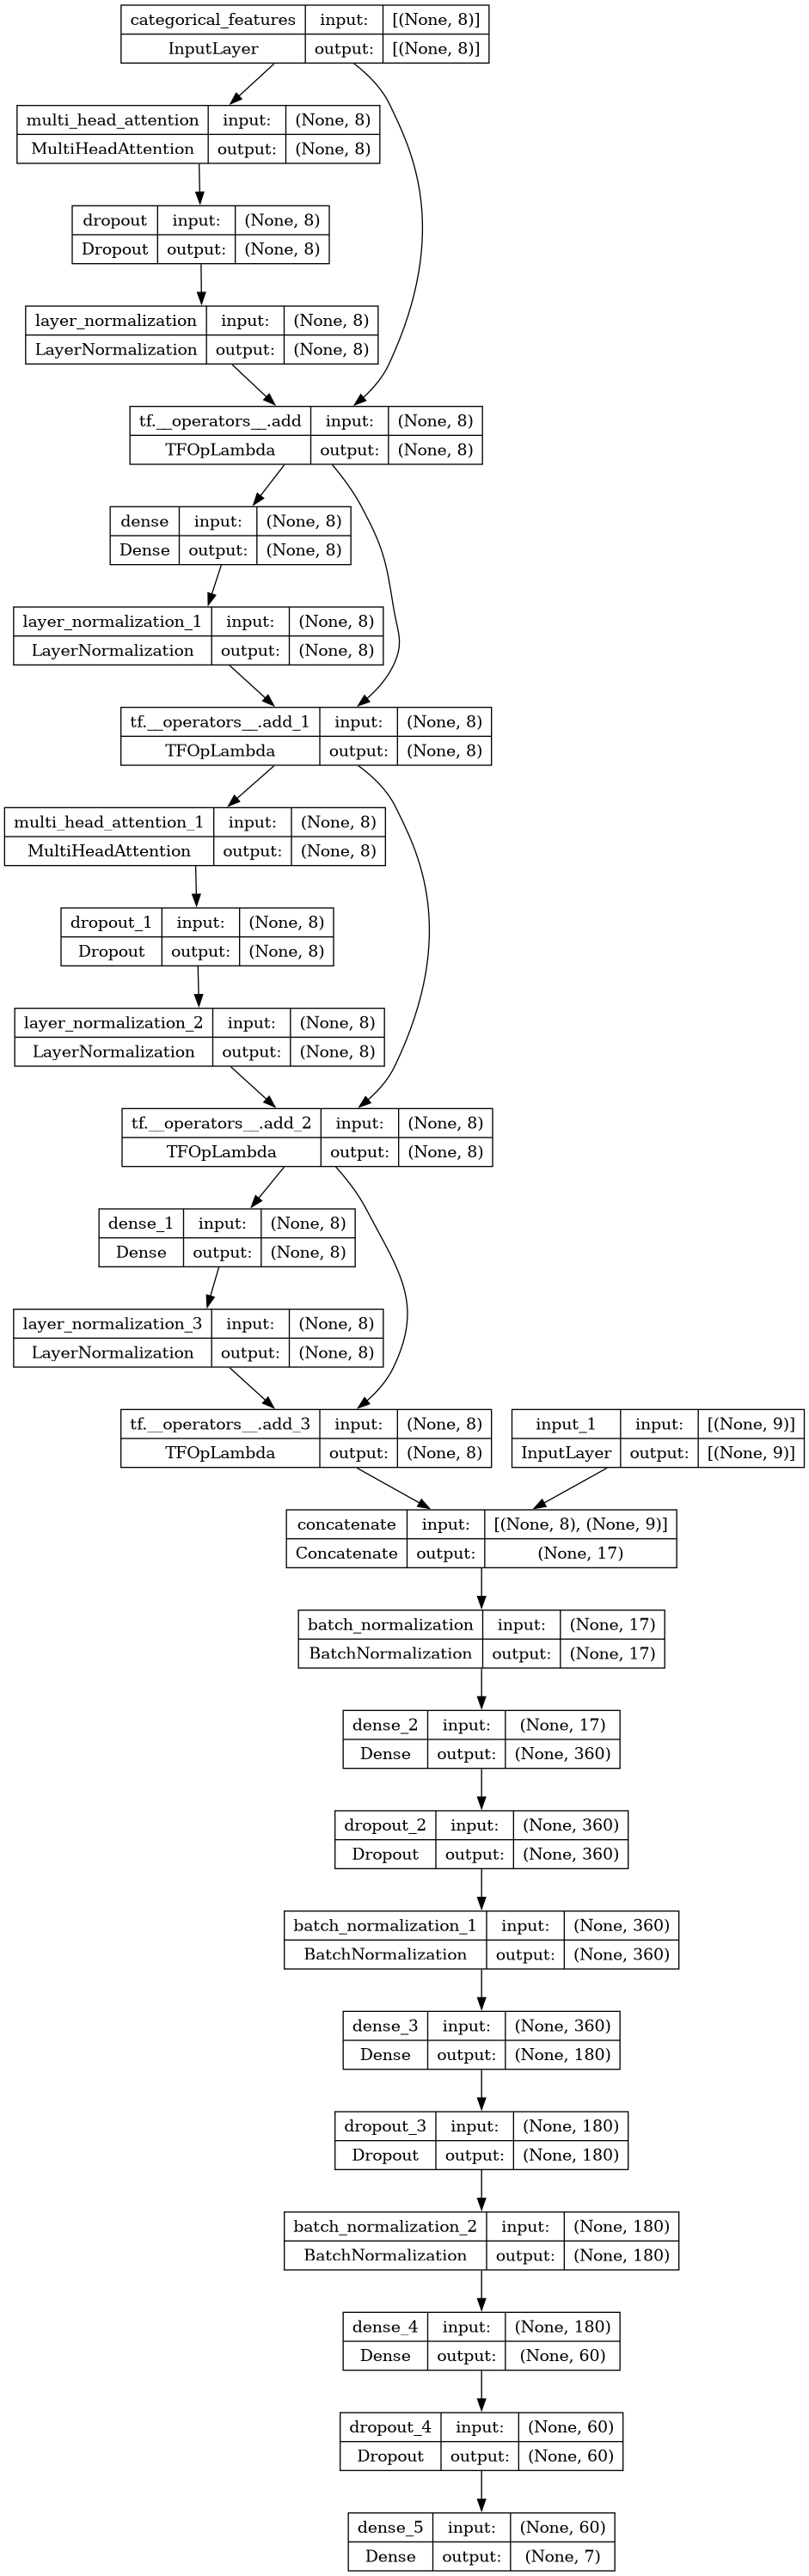

In [64]:
set_random_seed(0)
model_dnn = create_dnn_classifier(lr=0.011268992768380042,
                                  num_transformer_blocks=2,
                                  num_heads=1,
                                  key_dim=30,
                                  mlp_hidden_units_factors=[18, 9, 3],
                                  dropout1=0.5313112359203193,
                                  dropout2=0.1413692812748693,
                                  stddev=0.2591314155892278)
plot_model(model_dnn, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [65]:
model_dnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 categorical_features (Inpu  [(None, 8)]                  0         []                            
 tLayer)                                                                                          
                                                                                                  
 multi_head_attention (Mult  (None, 8)                    1058      ['categorical_features[0][0]',
 iHeadAttention)                                                     'categorical_features[0][0]']
                                                                                                  
 dropout (Dropout)           (None, 8)                    0         ['multi_head_attention[1][0]']
                                                                                              

In [66]:
clear_output()
collect()
hist=model_dnn.fit( train_ds_nn, validation_data=valid_ds_nn, epochs=1000,  verbose=1, callbacks=[call(),ClearMemory()])

dnn_preds, _=predict(model_dnn, test_ds_nn)
dnn_results=return_accuracy(y_test, dnn_preds)

5/5 [==============================] - 0s 3ms/step
****** Overall Accuracy Score ********
0.882466281310212




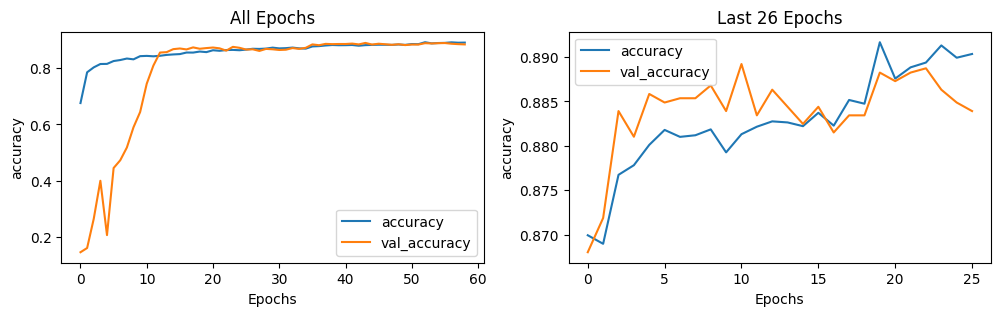

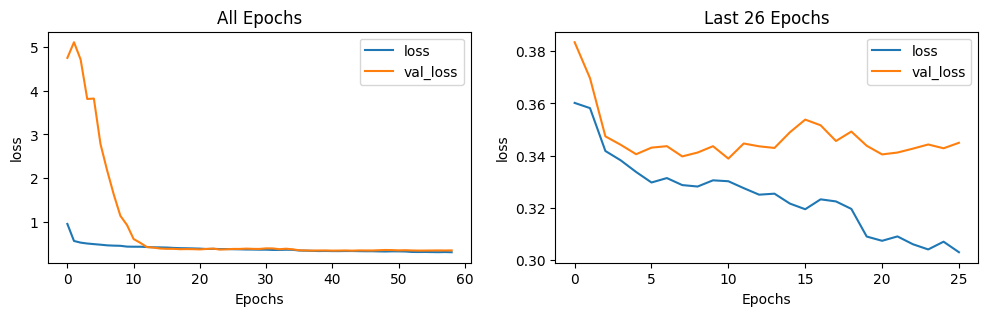

In [67]:
plot_epoch_graphs(hist, "accuracy")
plot_epoch_graphs(hist, "loss")

## Cross-validation

In [68]:
mean_acc_dnn, std_dnn=cv_nn(X=X_train_cv,
                            y=y_train_cv,
                            cv=cv,
                            cat_feat=CATEGORICAL_FEATURES_NN,
                            num_feats=NUMERIC_FEATURES_NN,
                            model=create_dnn_classifier(lr=0.011268992768380042,
                                  num_transformer_blocks=2,
                                  num_heads=1,
                                  key_dim=30,
                                  mlp_hidden_units_factors=[18, 9, 3],
                                  dropout1=0.5313112359203193,
                                  dropout2=0.1413692812748693,
                                  stddev=0.2591314155892278))

mean accuracy:0.8967058613258357, std: 0.011861213004098677


# Predicting Test set

In [69]:
y_final_all, _=predict(model_dnn,final_ds_nn)

y_final_all_text_array=le.inverse_transform(tf.math.argmax(y_final_all, -1).numpy())
output_all = pd.DataFrame({'id': df_test.index.values, 'NObeyesdad': y_final_all_text_array})
output_all.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

28/28 [==============================] - 0s 3ms/step
Your submission was successfully saved!
